**Hunter Mitchell**

**Movie Popularity Prediction Project**

**September 22nd, 2020**

# Intro

***What makes a movie popular?***

This project attempts to answer that question by examining various factors of films including budget, run time, genre, language and rating!

We will utilize Machine Learning and Data Science fundamentals to create a model that will predict a movie's popularity. This could be useful for film companies to determine what factors into a movie's popularity, or for other content creators to better understand their audience.

The data I am using is obtained from a Kaggle dataset found [here](https://www.kaggle.com/tmdb/tmdb-movie-metadata). I encourage anyone to explore the data for themselves and predict other potentially useful imformation (revenue, rating, etc.) 

We must also verify four main assumptions to get valid results from Linear Regression. These are:

1.   Linearity between features and target
2.   Multivariate normality
3.   Little multicollinearity
4.   Homoscedasticity 

We will examine each of these before implementing a Linear Regression model. Now let's get started!

# Getting to know our data

Let's begin by importing some necessary libraries so that we can explore our data!

In [1]:
import pandas as pd # for dataframes
import numpy as np # for arrays & math functions

%matplotlib inline
import matplotlib.pyplot as plt # for plotting

import warnings
warnings.filterwarnings('ignore') # ignoring any warnings

In [2]:
PATH = '/content/tmdb_5000_movies.csv'

movies_df = pd.read_csv(PATH) # load data into a pandas dataframe

Let's take a look at a couple instances to see what information we have

In [3]:
SEED = 2020 # for reproducability

movies_df.sample(3,random_state=SEED)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
1240,35000000,"[{""id"": 18, ""name"": ""Drama""}]",NaN,12184,"[{""id"": 392, ""name"": ""england""}, {""id"": 1156, ...",en,The Other Boleyn Girl,"A sumptuous and sensual tale of intrigue, roma...",22.939557,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2008-02-28,0,115.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Two sisters divided for the love of a king.,The Other Boleyn Girl,6.4,477
4354,0,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...",NaN,361475,"[{""id"": 237, ""name"": ""gay""}]",en,Departure,An English mother and her teenage son spend a ...,0.425830,"[{""name"": ""British Film Institute (BFI)"", ""id""...","[{""iso_3166_1"": ""FR"", ""name"": ""France""}, {""iso...",2016-05-20,0,109.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,NaN,Departure,7.5,12
2319,17000000,"[{""id"": 35, ""name"": ""Comedy""}]",NaN,10402,"[{""id"": 1357, ""name"": ""fish""}, {""id"": 2269, ""n...",en,Deuce Bigalow: Male Gigolo,"Deuce Bigalow is a less than attractive, down ...",9.832326,"[{""name"": ""Happy Madison Productions"", ""id"": 2...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1999-12-10,65535067,88.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,He charges $10 but he’s willing to negotiate.,Deuce Bigalow: Male Gigolo,5.5,308


We can see already that there is some missing data that we will need to take care of. There are also entries of zero that could be false.

According to the dataset, popularity is measured as the cumulative number of star ratings. It is also unknown whether the budget and revenue are in USD or some other currency. 

Let's look at all of our different columns.


In [4]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

As you can see, we have 19 columns to work with. Many of these will not correlate to popularity, though.

Overall, we don't have many null values. There are a lot in the homepage column, but that shouldn't be correlated to popularity, so we can safely ignore it as a feature. Our dataset contains 4,803 instances: not a ton, but it should be plenty for a regression model.

Now let's check out our target variable 'popularity'.

In [5]:
movies_df['popularity'].describe()

count    4803.000000
mean       21.492301
std        31.816650
min         0.000000
25%         4.668070
50%        12.921594
75%        28.313505
max       875.581305
Name: popularity, dtype: float64

It looks like we may have a few outliers present. To see if those are valid instances or not, let's look at the corresponding rows.

In [6]:
movies_df.sort_values(by='popularity',ascending=False)[:5]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
546,74000000,"[{""id"": 10751, ""name"": ""Family""}, {""id"": 16, ""...",http://www.minionsmovie.com/,211672,"[{""id"": 3487, ""name"": ""assistant""}, {""id"": 179...",en,Minions,"Minions Stuart, Kevin and Bob are recruited by...",875.581305,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2015-06-17,1156730962,91.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Before Gru, they had a history of bad bosses",Minions,6.4,4571
95,165000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 18, ""...",http://www.interstellarmovie.net/,157336,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",en,Interstellar,Interstellar chronicles the adventures of a gr...,724.247784,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""CA"", ""name"": ""Canada""}, {""iso...",2014-11-05,675120017,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Mankind was born on Earth. It was never meant ...,Interstellar,8.1,10867
788,58000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.foxmovies.com/movies/deadpool,293660,"[{""id"": 2095, ""name"": ""anti hero""}, {""id"": 307...",en,Deadpool,Deadpool tells the origin story of former Spec...,514.569956,"[{""name"": ""Twentieth Century Fox Film Corporat...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2016-02-09,783112979,108.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Witness the beginning of a happy ending,Deadpool,7.4,10995
94,170000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 878, ""na...",http://marvel.com/guardians,118340,"[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",en,Guardians of the Galaxy,"Light years from Earth, 26 years after being a...",481.098624,"[{""name"": ""Marvel Studios"", ""id"": 420}, {""name...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2014-07-30,773328629,121.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,All heroes start somewhere.,Guardians of the Galaxy,7.9,9742
127,150000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.madmaxmovie.com/,76341,"[{""id"": 2964, ""name"": ""future""}, {""id"": 3713, ...",en,Mad Max: Fury Road,An apocalyptic story set in the furthest reach...,434.278564,"[{""name"": ""Village Roadshow Pictures"", ""id"": 7...","[{""iso_3166_1"": ""AU"", ""name"": ""Australia""}, {""...",2015-05-13,378858340,120.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,What a Lovely Day.,Mad Max: Fury Road,7.2,9427


Wow! I rememeber the Minions movie being popular but not *that* popular! The other top movies seem valid as well - I was working at a movie theater when Deadpool came out, and it was massively popular!

Although these are outliers, they are still valid instances, and thus we will not modify or drop any of them.

Now let's look at some of the lowest popularities.

In [7]:
movies_df.sort_values(by='popularity',ascending=True)[:5]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
4553,0,[],NaN,380097,[],en,America Is Still the Place,1971 post civil rights San Francisco seemed li...,0.000000,[],[],NaN,0,0.0,[],Released,NaN,America Is Still the Place,0.0,0
3361,0,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 28, ""nam...",NaN,77156,[],en,Alien Zone,A man who is having an affair with a married w...,0.000372,[],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1978-11-22,0,90.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Don't you dare go in there!,Alien Zone,4.0,3
4727,0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 18, ""nam...",NaN,65448,"[{""id"": 378, ""name"": ""prison""}, {""id"": 209476,...",en,Penitentiary,A hitchhiker named Martel Gordone gets in a fi...,0.001117,[],[],1979-12-01,0,99.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"There's only one way out, and 100 fools stand ...",Penitentiary,4.9,8
4118,0,[],NaN,325140,[],en,Hum To Mohabbat Karega,"Raju, a waiter, is in love with the famous TV ...",0.001186,[],[],2000-05-26,0,0.0,[],Released,NaN,Hum To Mohabbat Karega,0.0,0
4625,0,"[{""id"": 27, ""name"": ""Horror""}]",NaN,426067,[],en,Midnight Cabaret,A Broadway producer puts on a play with a Devi...,0.001389,[],[],1990-01-01,0,94.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The hot spot where Satan's waitin'.,Midnight Cabaret,0.0,0


This provides insight into what type of instances we may need to drop - two of these have a runtime of 0! We can also see some missing or suspicious values that we will need to look at. Furthermore, I'm a bit worried about instances when the vote count is very low, as this will make vote average not representative. Let's look at some of the vote average extremes.

In [8]:
movies_df.sort_values(by='vote_average', ascending = False)[:5]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
3519,0,"[{""id"": 35, ""name"": ""Comedy""}]",NaN,89861,"[{""id"": 131, ""name"": ""italy""}, {""id"": 8250, ""n...",en,Stiff Upper Lips,Stiff Upper Lips is a broad parody of British ...,0.356495,[],"[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",1998-06-12,0,99.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,Stiff Upper Lips,10.0,1
4247,1,"[{""id"": 10749, ""name"": ""Romance""}, {""id"": 35, ...",NaN,361505,[],en,Me You and Five Bucks,"A womanizing yet lovable loser, Charlie, a wai...",0.094105,[],[],2015-07-07,0,90.0,[],Released,"A story about second, second chances",Me You and Five Bucks,10.0,2
4045,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",NaN,78373,"[{""id"": 1415, ""name"": ""small town""}, {""id"": 15...",en,"Dancer, Texas Pop. 81","Four guys, best friends, have grown up togethe...",0.376662,"[{""name"": ""HSX Films"", ""id"": 4714}, {""name"": ""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1998-05-01,565592,97.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,in the middle of nowhere they had everything,"Dancer, Texas Pop. 81",10.0,1
4662,0,"[{""id"": 35, ""name"": ""Comedy""}]",NaN,40963,"[{""id"": 10183, ""name"": ""independent film""}]",en,Little Big Top,An aging out of work clown returns to his smal...,0.092100,"[{""name"": ""Fly High Films"", ""id"": 24248}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2006-01-01,0,0.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Rumored,NaN,Little Big Top,10.0,1
3992,0,[],NaN,346081,[],en,Sardaarji,A ghost hunter uses bottles to capture trouble...,0.296981,[],"[{""iso_3166_1"": ""IN"", ""name"": ""India""}]",2015-06-26,0,0.0,[],Released,NaN,Sardaarji,9.5,2


Sure enough, the movies with the best vote averages were only reviewed one or two times! We will have to cut off a certain threshold of vote counts to fix this.

Now let's take a look at the different languages we have.

In [9]:
movies_df['original_language'].value_counts()

en    4505
fr      70
es      32
zh      27
de      27
hi      19
ja      16
it      14
cn      12
ko      11
ru      11
pt       9
da       7
sv       5
nl       4
fa       4
th       3
he       3
ta       2
cs       2
ro       2
ar       2
id       2
nb       1
vi       1
te       1
xx       1
hu       1
pl       1
tr       1
ky       1
no       1
ps       1
sl       1
el       1
af       1
is       1
Name: original_language, dtype: int64

(-1.107919947587085,
 1.1071445050016366,
 -1.110482490994638,
 1.1827216234688134)

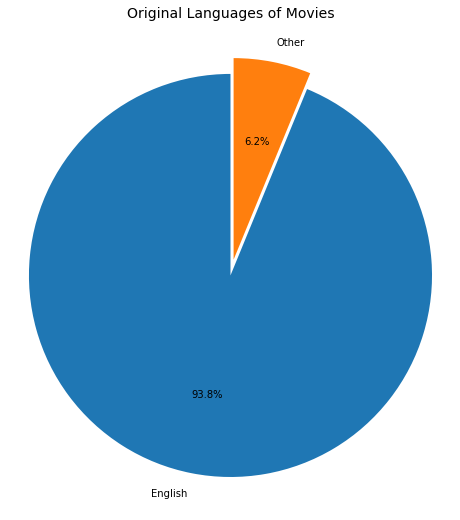

In [10]:
### Pie Chart

labels = np.array(['English','Other'])
sizes = np.array([4505, sum(movies_df['original_language'].value_counts()) - 4505])

plt.figure(figsize=(8,9))

plt.pie(sizes, labels=labels, autopct='%1.1f%%', explode=[0,0.08], startangle=90)
plt.title('Original Languages of Movies', fontdict={'fontsize': 14})
plt.axis('equal')

93.8% of the movies are in english. There are a few different ways we could encode this column. One method would be to one-hot encode by creating a binary column for each different language. This would add a ton of new features to the data, with some only having 1 or 2 positive instances. Another way we could encode this is by converting it to just english or not english. This would only add one column and likely contribute to popularity still.

# Cleaning

Let's create our features dataframe and clean it up a bit. I am choosing all the features that I believe impact a movies popularity. I am also leaving out revenue as a feature, as this is something revealed a while after a movie comes out.

In [11]:
features_df = movies_df[['budget','genres','original_language','runtime','vote_average','vote_count']]
labels_df = movies_df['popularity']

First let's drop any rows with null values

In [12]:
features_df = features_df.dropna()

Now let's drop instances with very few vote counts. I decided to have 10 as the cutoff - if 10 or more people voted, it will likely have a fairly accurate vote average. 

In [13]:
features_df = features_df[features_df['vote_count'] >= 10]

Now let's drop any values with a runtime of zero

In [14]:
features_df = features_df[features_df['runtime'] != 0.0]

And lastly, we have to set the labels dataframe to only include the rows of the new features dataframe

In [15]:
labels_df = labels_df[features_df.index]

Now let's get some insight into our cleaned features

In [16]:
features_df.describe()

,budget,runtime,vote_average,vote_count
count,4.386000e+03,4386.000000,4386.000000,4386.000000
mean,3.168441e+07,108.554492,6.228659,755.455084
std,4.164199e+07,20.705083,0.891691,1272.838558
min,0.000000e+00,25.000000,1.900000,10.000000
25%,2.917508e+06,95.000000,5.700000,84.000000
50%,1.700000e+07,105.000000,6.300000,290.000000
75%,4.200000e+07,119.000000,6.800000,831.750000
max,3.800000e+08,338.000000,8.500000,13752.000000


We can already see that the average vote column has no zeros and no 10s, which is good. Furthermore, the shortest runtime is 25 minutes and the longest is 338 minutes, which seem accurate.

There seem to be some films that have a budget of 0. We will keep these as valid because there are plenty of low-budget films (think Blair Witch Project)

# Exploratory Data Analysis

Now it is time to split our data into training and testing data. This is crucial, as we do not want to notice any overall patterns before our models run. We will only use the training data from now on and use our testing data to test our final models.

In [17]:
from sklearn.model_selection import train_test_split

# split data into 80% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(features_df, labels_df, test_size=0.2, random_state = SEED)

Let's look at our target variable distribution by plotting a histogram.

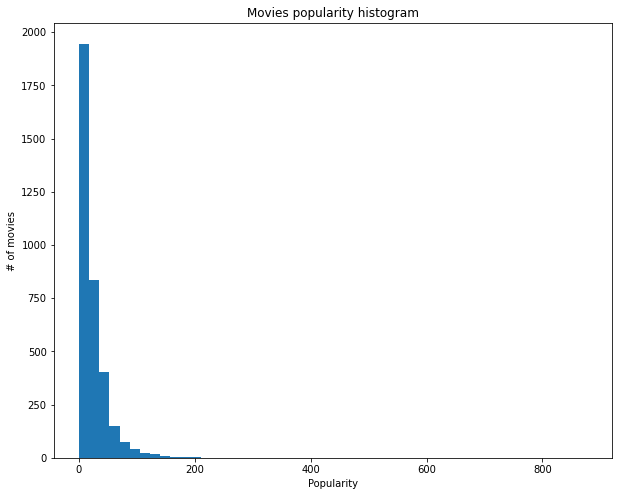

In [18]:
# Plot histogram
plt.figure(figsize=(10,8))
plt.hist(y_train.values,bins=50)
plt.title('Movies popularity histogram')
plt.xlabel('Popularity')
plt.ylabel('# of movies')
plt.show()

The data is heavily skewed left. The skew method will return how asymmetric the data is (with zero being completely symmetric)

In [19]:
y_train.skew()

10.183364196727132

Linear regression should have all variables be approximately normal, so let's fix this. There are a couple ways we could deal with skewed distributions. These include applying logarithms, square roots, or using the box cox method. I am going to use the log method here. Note that we have to do this to our testing data too. 

In [20]:
y_train = np.log(y_train)
y_test = np.log(y_test)

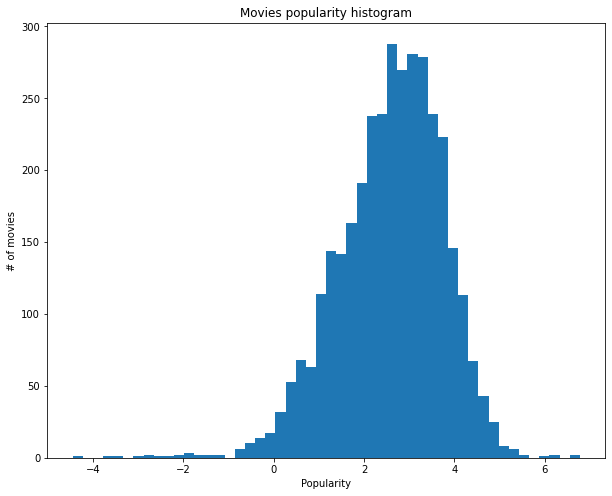

In [21]:
# Plot histogram
plt.figure(figsize=(10,8))
plt.hist(y_train.values,bins=50)
plt.title('Movies popularity histogram')
plt.xlabel('Popularity')
plt.ylabel('# of movies')
plt.show()

That looks much better, but let's verify by checking the skew

In [22]:
print('Popularity skew:', y_train.skew())

Popularity skew: -0.6371952981496516


Great! Now let's look at the numerical features

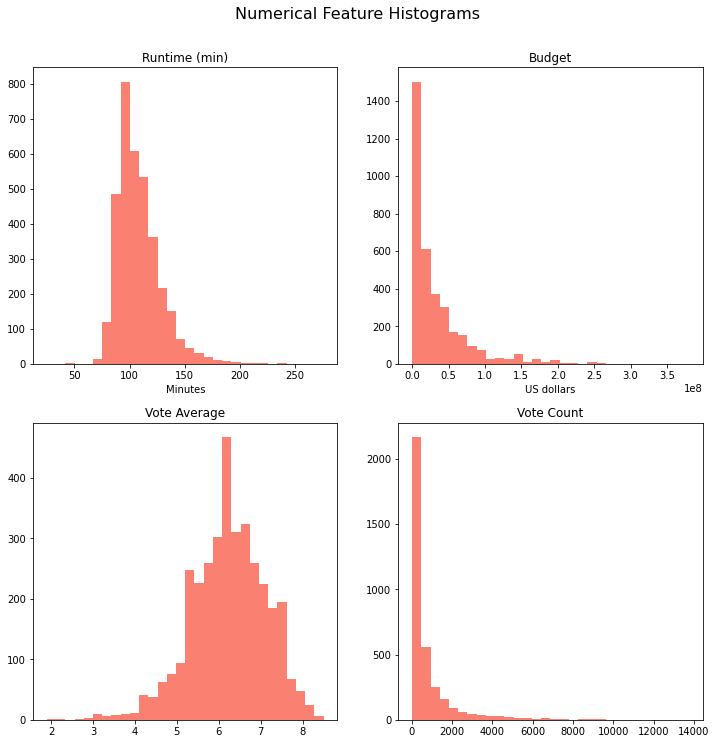

In [23]:
### Plot histograms
plt.rcParams['figure.figsize'] = 12, 12
fig, axs = plt.subplots(2,2)
fig.suptitle('Numerical Feature Histograms',y=0.95,fontsize=16)

axs[0,1].hist(x_train['budget'].values,bins=30,color='salmon')
axs[0,1].set_title('Budget')
axs[0,1].set(xlabel='US dollars')
axs[0,0].hist(x_train['runtime'].values,bins=30,color='salmon')
axs[0,0].set_title('Runtime (min)')
axs[0,0].set(xlabel='Minutes')
axs[1,0].hist(x_train['vote_average'].values,bins=30,color='salmon')
axs[1,0].set_title('Vote Average')
axs[1,1].hist(x_train['vote_count'].values,bins=30,color='salmon')
axs[1,1].set_title('Vote Count')
plt.show()

Both runtime and vote average seem fairly normal, but vote count and budget are definitely skewed.

In [24]:
print('Vote count skew:', x_train['vote_count'].skew())
print('Vote average skew:', x_train['vote_average'].skew())
print('Runtime skew:', x_train['runtime'].skew())
print('Budget skew:', x_train['budget'].skew())

Vote count skew: 3.741920907656624
Vote average skew: -0.4913710194811116
Runtime skew: 1.6605641919217837
Budget skew: 2.337119891576633


Let's normalize the budget and vote count variables. We will do another log transformation to vote count and do a square root transformation to budget. This is because budget contains zero values and taking the log of these would give us undefined values. 

In [25]:
x_train['vote_count'] = np.log(x_train['vote_count'].values)
x_train['budget'] = np.sqrt(x_train['budget'].values)

x_test['vote_count'] = np.log(x_test['vote_count'].values)
x_test['budget'] = np.sqrt(x_test['budget'].values)

Now let's look at the distributions and skew values

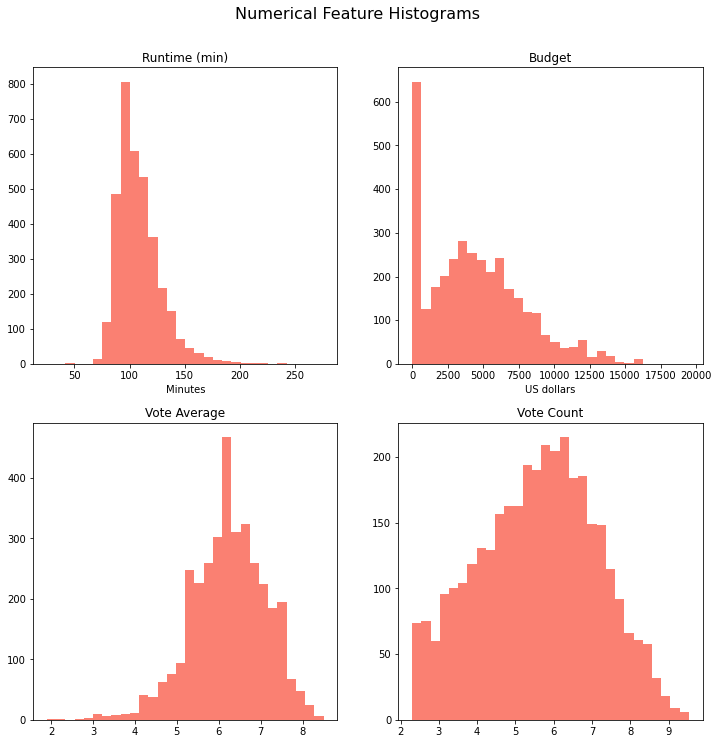

In [26]:
### Histograms

plt.rcParams['figure.figsize'] = 12, 12
fig, axs = plt.subplots(2,2)
fig.suptitle('Numerical Feature Histograms',y=0.95,fontsize=16)

axs[0,1].hist(x_train['budget'].values,bins=30,color='salmon')
axs[0,1].set_title('Budget')
axs[0,1].set(xlabel='US dollars')
axs[0,0].hist(x_train['runtime'].values,bins=30,color='salmon')
axs[0,0].set_title('Runtime (min)')
axs[0,0].set(xlabel='Minutes')
axs[1,0].hist(x_train['vote_average'].values,bins=30,color='salmon')
axs[1,0].set_title('Vote Average')
axs[1,1].hist(x_train['vote_count'].values,bins=30,color='salmon')
axs[1,1].set_title('Vote Count')
plt.show()

In [27]:
print(x_train['vote_count'].skew())
print(x_train['vote_average'].skew())
print(x_train['runtime'].skew())
print(x_train['budget'].skew())

-0.08525112323299636
-0.4913710194811116
1.6605641919217837
0.6463815735326411


We could work to normalize these more, but for the sake of this project, we will keep it how it is. Now that we have made the distributions more normal, let's look at the correlations between our variables.

<Figure size 864x864 with 0 Axes>

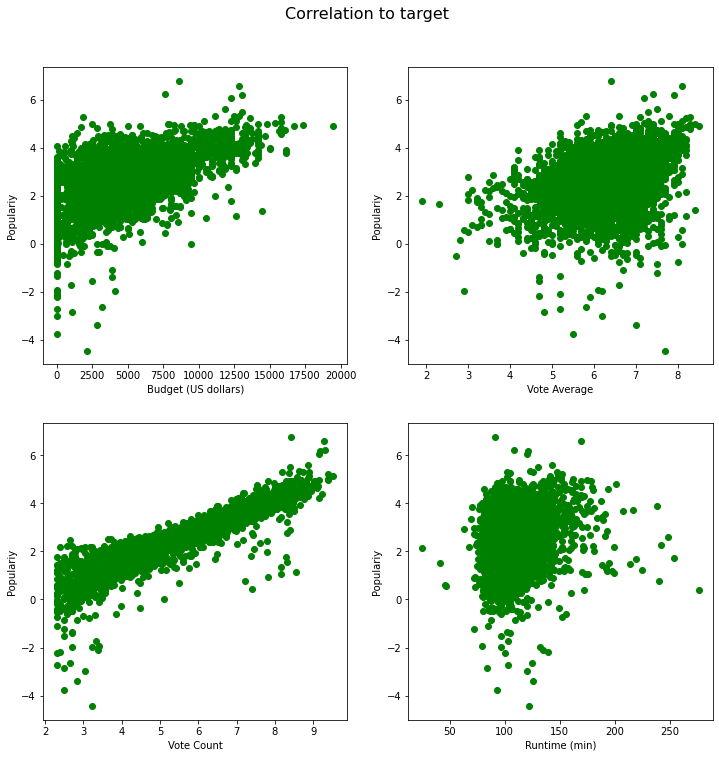

In [28]:
# Scatterplots

plt.figure(figsize=(12,12))

fig, axs = plt.subplots(2,2)
fig.suptitle('Correlation to target',y=0.95,fontsize=16)
axs[0,1].scatter(x_train['vote_average'].values, y_train.values,color='green')
axs[0,1].set(xlabel='Vote Average',ylabel='Populariy')
axs[0,0].scatter(x_train['budget'].values, y_train.values,color='green')
axs[0,0].set(xlabel='Budget (US dollars)',ylabel='Populariy')
axs[1,0].scatter(x_train['vote_count'].values, y_train.values,color='green')
axs[1,0].set(xlabel='Vote Count',ylabel='Populariy')
axs[1,1].scatter(x_train['runtime'].values, y_train.values,color='green')
axs[1,1].set(xlabel='Runtime (min)',ylabel='Populariy')
plt.show()

Vote count definitely looks the most correlated to popularity, but let's check their actual correlation coefficients.

In [29]:
corr_matrix = pd.concat([x_train,y_train],axis=1).corr()

corr_matrix['popularity'].sort_values(ascending=False)

popularity      1.000000
vote_count      0.916700
budget          0.585248
vote_average    0.331258
runtime         0.208239
Name: popularity, dtype: float64

Vote count is indeed the most correlated. The others are still correlated and we can now check off the linearity assumption of Linear Regression. We can also check off our homoscedasticity assumption as the residuals are approximately equal throughout each scatterplot. If they were not equal, we would see a strong cone shape. Now let's look at how our features correlate to each other.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4795897f0>,
      dtype=object)

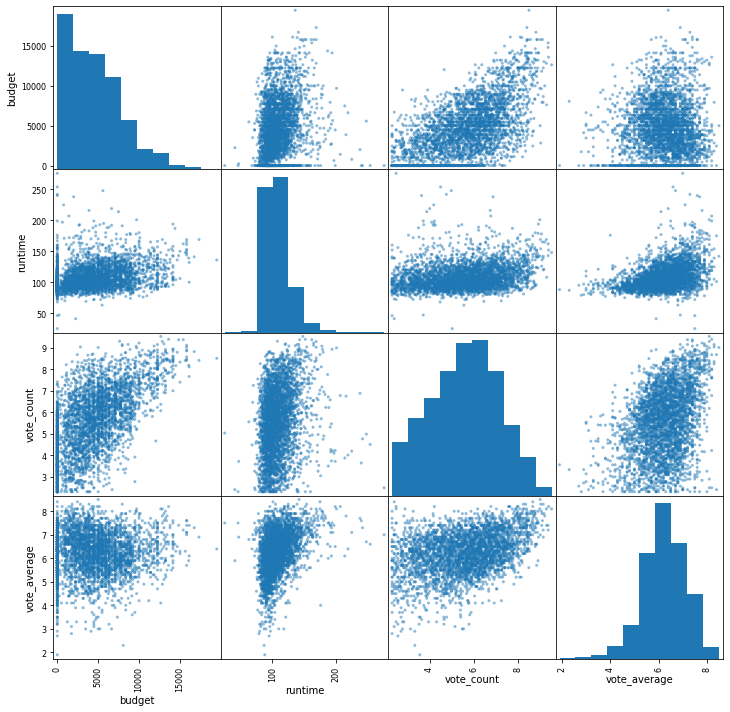

In [30]:
from pandas.plotting import scatter_matrix

scatter_matrix(x_train[['budget','runtime','vote_count','vote_average']], figsize=(12,12))

We can see that there may be a bit of correlation between our independent variables. Let's look at the correlation coefficients.

In [31]:
x_train.corr()

,budget,runtime,vote_average,vote_count
budget,1.000000,0.265104,0.032031,0.626242
runtime,0.265104,1.000000,0.391242,0.224152
vote_average,0.032031,0.391242,1.000000,0.379105
vote_count,0.626242,0.224152,0.379105,1.000000


While there is a bit more correlation between some independent variables than we would like, we will choose to ignore it for the scope of this project. Therefore, we now have considered all four assumptions and we can move on to getting the data ready for our models!

# Feature Engineering

We still have categorical features that we need to encode. 

For language, we will make a binary variable with 1 for english and 0 for non-english. 

In [32]:
### Encode language 

x_train['Language'] = x_train['original_language'].apply(lambda x: 1 if 'en' == x else 0)
x_test['Language'] = x_test['original_language'].apply(lambda x: 1 if 'en' == x else 0)

For genres, we will choose to one-hot encode them. Normally, we would use a OneHotEncoder class here, however it will not work with the genre objects we have. This is because every genre entry is a dict with all of the genres they contain, so a OneHotEncoder would make a unique column for each combination. We will have to do it manually.

In [33]:
genre_list = ['Action', 'Adventure', 'Fantasy', 'Science Fiction', 'Crime', 'Drama', 'Thriller', 'Animation',
 'Family', 'Western', 'Comedy', 'Romance', 'Horror', 'Mystery', 'History', 'War', 'Music']

In [34]:
# make column for each genre and encode it

for genre in genre_list:
  x_train[genre] = x_train['genres'].apply(lambda x: 1 if genre in x else 0)
  x_test[genre] = x_test['genres'].apply(lambda x: 1 if genre in x else 0)

In [35]:
x_train.describe()

,budget,runtime,vote_average,vote_count,Language,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,History,War,Music
count,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000
mean,4468.372312,108.669327,6.232326,5.583787,0.942702,0.253421,0.176739,0.096636,0.117161,0.150228,0.471209,0.275371,0.053022,0.109749,0.017104,0.371152,0.187856,0.106899,0.072691,0.039909,0.029361,0.038198
std,3470.419985,20.591803,0.890211,1.556430,0.232444,0.435032,0.381502,0.295504,0.321658,0.357346,0.499242,0.446765,0.224109,0.312621,0.129677,0.483182,0.390653,0.309028,0.259666,0.195773,0.168842,0.191702
min,0.000000,25.000000,1.900000,2.302585,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1732.050808,95.000000,5.700000,4.451423,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4242.640687,105.000000,6.300000,5.673323,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6633.249581,119.000000,6.900000,6.717805,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,19493.588690,276.000000,8.500000,9.528940,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
corr_matrix = pd.concat([x_train,y_train],axis=1).corr()

corr_matrix['popularity'].sort_values(ascending=False)

popularity         1.000000
vote_count         0.916700
budget             0.585248
vote_average       0.331258
Adventure          0.225227
runtime            0.208239
Action             0.170542
Fantasy            0.169853
Animation          0.139544
Science Fiction    0.130620
Language           0.121879
Thriller           0.102094
Family             0.094241
Crime              0.064300
Mystery            0.054000
War                0.017547
Western            0.003349
Horror            -0.019689
History           -0.026097
Music             -0.066077
Comedy            -0.105179
Romance           -0.109036
Drama             -0.137730
Name: popularity, dtype: float64

These results are interesting in themselves! It looks like the adventure and action genres correlate most positively to popularity, and comedy, romance, and drama correlate most negatively. There are a few genres that do not seem to correlate at all, but we will choose to keep them as features.

We also have to remember to drop our original categorical columns! 

In [37]:
x_train = x_train.drop(columns=['original_language','genres']) # drop encoded columns
x_test = x_test.drop(columns=['original_language','genres']) # drop encoded columns

Now let's scale our features. Machine Learning models tend to perform better when scaled.

In [38]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train),index=x_train.index, columns=x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test),index=x_test.index, columns=x_test.columns)

In [39]:
# Verify

x_train_scaled.head()

,budget,runtime,vote_average,vote_count,Language,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,History,War,Music
1057,0.280976,0.442231,0.818182,0.540243,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1385,0.303488,0.262948,0.560606,0.689833,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
887,0.369922,0.398406,0.575758,0.639062,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
585,0.416754,0.482072,0.772727,0.636163,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2167,0.229416,0.282869,0.787879,0.745183,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Perfect! Now we are finally ready to train some models!

# Model Selection

With the data all ready to go, it is finally time to train some models! Let's define a few lists to score our metrics, and a function to print them. The cross_val_score will use cross validation to score the model predictions on all parts of our training data. The main metric we will be looking at is Root Mean Squared Error. This is a common metrics for regression tasks. 

In [40]:
from sklearn.model_selection import cross_val_score

rmse_list = []
std_list = []

def get_score(model):
  cv_score = cross_val_score(model, x_train_scaled, y_train, scoring = "neg_mean_squared_error", cv = 8)
  rmse = np.sqrt(-cv_score)
  print('Cross-Validation Root Mean Squared Error:', rmse)
  print('Average Root Mean Squared Error:', round(np.mean(rmse), 5))
  rmse_list.append(round(np.mean(rmse), 5))
  print('Standard deviation:', round(rmse.std(), 5))
  std_list.append(round(rmse.std(), 5))

## Regression

We will begin with the classic linear regression models. Once again, the results and validity of these depend on the four assumptions that we already discussed. 



In [41]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [42]:
### Linear Regression

model_1 = LinearRegression()

model_1.fit(x_train_scaled,y_train)

get_score(model_1)

Cross-Validation Root Mean Squared Error: [0.46790618 0.47929483 0.40475996 0.52752017 0.43998442 0.46671215
 0.49695483 0.40076656]
Average Root Mean Squared Error: 0.46049
Standard deviation: 0.04087


Ridge regression adds a regularization term to the cost function which helps prevent overfitting. The term added is the sum of the square of the coefficients.

In [43]:
### Ridge Regression

model_2 = Ridge(random_state=SEED)

model_2.fit(x_train_scaled,y_train)

get_score(model_2)

Cross-Validation Root Mean Squared Error: [0.46839053 0.47980163 0.40495568 0.52782219 0.43947397 0.46715904
 0.49719715 0.39997857]
Average Root Mean Squared Error: 0.4606
Standard deviation: 0.04115


Lasso regression also adds a regularization term to the cost function, but this time it is the sum of the magnitudes of the coefficients.

In [44]:
### Lasso Regression

model_3 = Lasso(random_state=SEED)

model_3.fit(x_train_scaled,y_train)

get_score(model_3)

Cross-Validation Root Mean Squared Error: [1.12133568 1.1305347  1.19897781 1.22260575 1.11519697 1.222047
 1.18672387 1.07410068]
Average Root Mean Squared Error: 1.15894
Standard deviation: 0.05213


## Random Forest

Random Forest is a simple yet powerful machine learning model. It uses many decision trees to make it's final decision. 

In [45]:
from sklearn.ensemble import RandomForestRegressor

In [46]:
model_4 = RandomForestRegressor(random_state=SEED)

model_4.fit(x_train_scaled,y_train)

get_score(model_4)

Cross-Validation Root Mean Squared Error: [0.50136732 0.53030541 0.42257631 0.53852953 0.49220586 0.47617066
 0.51228452 0.42431413]
Average Root Mean Squared Error: 0.48722
Standard deviation: 0.04123


## Support Vector Regressor

Support Vector Machines are typically used for classification tasks, but they can be used for regression as well.

In [47]:
from sklearn.svm import SVR

In [48]:
model_5 = SVR()

model_5.fit(x_train_scaled,y_train)

get_score(model_5)

Cross-Validation Root Mean Squared Error: [0.47328369 0.49078863 0.42661852 0.51307526 0.44749369 0.48420984
 0.51831062 0.40679701]
Average Root Mean Squared Error: 0.47007
Standard deviation: 0.03745


## XGBoost

XGBoost uses gradient boosted trees to make it's decision. They often outperform most models when the hyperparameters are tuned correctly.

In [49]:
from xgboost import XGBRegressor

In [50]:
model_6 = XGBRegressor(random_state=SEED,verbose=0,objective='reg:squarederror')

model_6.fit(x_train_scaled,y_train)

get_score(model_6)

Cross-Validation Root Mean Squared Error: [0.46343496 0.48944193 0.4103061  0.52311562 0.44710536 0.47135289
 0.502381   0.40480992]
Average Root Mean Squared Error: 0.46399
Standard deviation: 0.03928


## Neural Network

Neural Networks have been around for a while, but have recently taken over all areas of machine learning with architecture advancements and better processing units.  

In [51]:
import tensorflow as tf
import tensorflow.keras.layers as L
from keras.wrappers.scikit_learn import KerasRegressor

I played with the architecture a bit (number of layers, dropout, neurons per layer, etc.) and this seemed to yield the best results.

In [52]:
def get_tf_model():
    model = tf.keras.Sequential([
        L.Input(shape=(x_train_scaled.shape[1])),
        L.Dense(250, activation='relu'),
        L.BatchNormalization(),
        L.Dense(200, activation='relu'),
        L.BatchNormalization(),
        L.Dense(200, activation='relu'),
        L.BatchNormalization(),
        L.Dense(1)
    ])

    model.compile(
        optimizer='adam',
        loss = 'mse',
        metrics=['accuracy','mse']
    )
    
    return model

In [53]:
get_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 250)               5750      
_________________________________________________________________
batch_normalization (BatchNo (None, 250)               1000      
_________________________________________________________________
dense_1 (Dense)              (None, 200)               50200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
batch_normalization_2 (Batch (None, 200)               800       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2

In [54]:
model_7 = KerasRegressor(build_fn = get_tf_model, epochs = 10, verbose = 0, batch_size = 100)
model_7.fit(x_train_scaled,y_train.values)

In [55]:
get_score(model_7)

Cross-Validation Root Mean Squared Error: [0.74371637 0.85498139 0.77448236 0.8306035  0.75343165 0.83006459
 0.78818831 0.70647751]
Average Root Mean Squared Error: 0.78524
Standard deviation: 0.04743


## Cross-Validation Scores

Let's see how the models compare

In [56]:
# For creating tables that render in Github
!pip install --upgrade plotly
!pip install -U kaleido

Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.11.0)
Requirement already up-to-date: kaleido in /usr/local/lib/python3.6/dist-packages (0.0.3.post1)


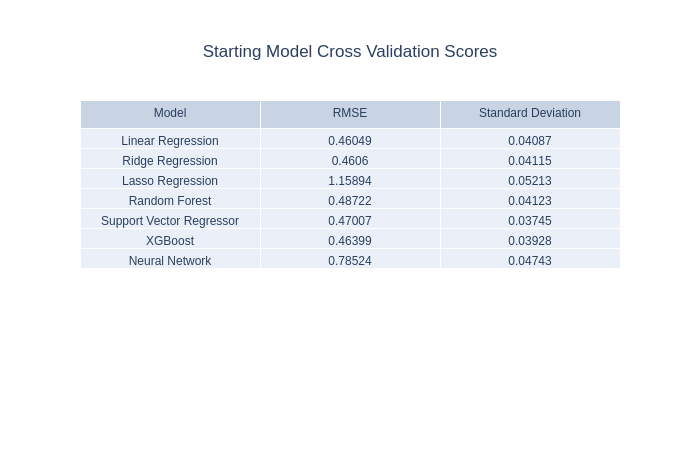

In [57]:
import plotly.graph_objects as go

# Create table

models_list = ['Linear Regression','Ridge Regression','Lasso Regression','Random Forest', 
               'Support Vector Regressor','XGBoost', 'Neural Network']

fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'RMSE', 'Standard Deviation']),
                 cells=dict(values=[models_list, rmse_list, std_list]))
                     ])

fig.update_layout(
    title={
        'text': "Starting Model Cross Validation Scores",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show("png")

Regular Linear Regression and Ridge Regression perform the best. Lasso Regression definitely performs worse - probably because the hyperparameters aren't tuned. XGBoost, Random Forest, and Support Vector Regressor also perform well. Neural Networks kind of let us down, but if we played with the structure more, I'm sure we could make it better.

# Hyperparameter Tuning

Let's try to improve some of these scores. Kaggle competitors may spend days or even weeks figuring out the best hyperparameters for their models as well as which models to ensemble. 


We will just pick a few to improve by using grid search. Grid search reveals which hyperparameter combinations provide the best results by trying many different combinations from what you give it.

In [58]:
from sklearn.model_selection import GridSearchCV

# Enter model and parameter options and returns best model
def grid_search(model,params):
  search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error')
  search.fit(x_train_scaled,y_train)
  return search.best_estimator_

### Lasso

Lasso performed the worst, so let's try to improve it by first looking at what parameters there are.

In [59]:
model_3.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': 2020,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

We'll pick some options, and apply gird search

In [60]:
param_grid = [
              {'alpha': [0.1,0.05,0.01,0.005] , 
               "fit_intercept": [True, False], 
               'normalize': [True, False],
               "tol": [0.0005,.0001,0.00005]}
]

model_3_grid = grid_search(model_3,param_grid)

model_3_grid.get_params() # these will be our new parameters

{'alpha': 0.005,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': 2020,
 'selection': 'cyclic',
 'tol': 0.0005,
 'warm_start': False}

In [61]:
get_score(model_3_grid)

Cross-Validation Root Mean Squared Error: [0.47050766 0.48125268 0.4045811  0.5291237  0.44392033 0.47066828
 0.49413479 0.40033284]
Average Root Mean Squared Error: 0.46182
Standard deviation: 0.04105


Wow! Just like that our RMSE improved a lot!

### Support Vector Regressor

Now let's try it for Support Vector Regressor

In [62]:
# Support Vector Regression

model_5.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [63]:
param_grid = [
              {'kernel': ['linear', 'rbf'],
               'tol': [0.015, 0.01],
               'epsilon': [0.2, 0.15] }
]

model_5_grid = grid_search(model_5,param_grid)

model_5_grid.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.2,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.01,
 'verbose': False}

In [64]:
get_score(model_5_grid)

Cross-Validation Root Mean Squared Error: [0.46686479 0.48061054 0.40452317 0.52955217 0.44275658 0.46870747
 0.49156258 0.40244178]
Average Root Mean Squared Error: 0.46088
Standard deviation: 0.04041


### XGBoost

And lastly we will use grid search on our XGBoost model

In [65]:
model_6.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:squarederror',
 'random_state': 2020,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbose': 0,
 'verbosity': 1}

In [66]:
param_grid = [
              {'gamma': [10,5],
               'max_depth': [7,5],
               'min_child_weight': [30,20],
               'learning_rate': [0.05,0.01]}
]

model_6_grid = grid_search(model_6,param_grid)

model_6_grid.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 5,
 'importance_type': 'gain',
 'learning_rate': 0.05,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 30,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:squarederror',
 'random_state': 2020,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbose': 0,
 'verbosity': 1}

In [67]:
get_score(model_6_grid)

Cross-Validation Root Mean Squared Error: [0.46765352 0.48877596 0.41202227 0.52867279 0.43131187 0.47989493
 0.50520237 0.39973979]
Average Root Mean Squared Error: 0.46416
Standard deviation: 0.04281


### Comparison

We could do this all day to zero in on the absolute best hyperparemters, but for the sake of this project, we will stop here. Let's look at the comparisons

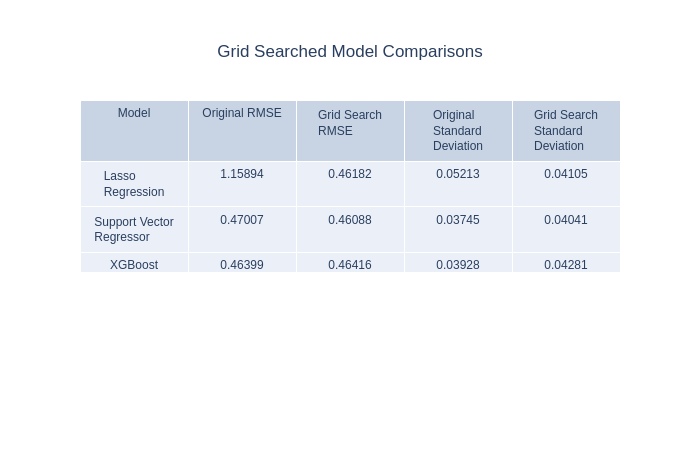

In [68]:
# Create table

models_list = ['Lasso Regression','Support Vector Regressor','XGBoost']

fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Original RMSE', 'Grid Search RMSE', 
                                                   'Original Standard Deviation', 'Grid Search Standard Deviation']),
                 cells=dict(values=[models_list, [rmse_list[2], rmse_list[4], rmse_list[5]], rmse_list[-3:],
                                    [std_list[2], std_list[4], std_list[5]], std_list[-3:]]))
                     ])

fig.update_layout(
    title={
        'text': "Grid Searched Model Comparisons",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})


fig.show("png")

Grid search improved Lasso by a lot, improved Support Vector by a bit, and actually didn't improve XGBoost. This is why it is important to keep trying different combinations of hyperparameter values to see what works. It also improved standard deviation in Lasso and Support Vector, but made XGBoost worse.

# Results

Up to this point, we have only looked at our training data. Now we can try out our models on the test data to see how they perform on data they have never seen. We will first declare some arrays to store our predictions and scores, and make a function to calculate the Root Mean Squared Error. 

It is also very important to note that the popularity predictions we get will be the logarithm of the actual popularity predictions. Hence, to get the real popularity prediction, we must take the exponential. This is because we need to reverse the log function we applied earlier when we normalized our target variable. 

In [69]:
from sklearn.metrics import mean_squared_error

predictions = []
final_scores = []

def get_results(preds):
  score = np.sqrt(mean_squared_error(preds,y_test.values))
  final_scores.append(round(score,5))

Now we can make test predictions for each model

In [70]:
### Regression

preds = np.array(model_1.predict(x_test_scaled))
predictions.append(preds)
get_results(preds)


### Ridge

preds = np.array(model_2.predict(x_test_scaled))
predictions.append(preds)
get_results(preds)


### Lasso

preds = np.array(model_3.predict(x_test_scaled))
predictions.append(preds)
get_results(preds)


### Forest

preds = np.array(model_4.predict(x_test_scaled))
predictions.append(preds)
get_results(preds)


### SVR

preds = np.array(model_5.predict(x_test_scaled))
predictions.append(preds)
get_results(preds)


### XGBoost

preds = np.array(model_6.predict(x_test_scaled))
predictions.append(preds)
get_results(preds)


### Neural Network

preds = model_7.predict(x_test_scaled).reshape(len(x_test_scaled))
predictions.append(preds)
get_results(preds)


### Grid searched Lasso

preds = np.array(model_3_grid.predict(x_test_scaled))
predictions.append(preds)
get_results(preds)


### Grid searched SVR

preds = np.array(model_5_grid.predict(x_test_scaled))
predictions.append(preds)
get_results(preds)


### Grid searched XGBoost

preds = np.array(model_6_grid.predict(x_test_scaled))
predictions.append(preds)
get_results(preds)

And just for fun, let's try to ensemble some of these predictions and see how they do. The first ensemble will be an average of every model we have made up to this point. The second ensemble will be an average of just the three grid searched models. The third ensemble will be an average of our top three models up to this point (Linear Regression, Ridge Regression, Grid searched Support Vector Regressor). 


In [71]:
# average all model predictions
ensemble_1 = np.mean(predictions,axis=0) 
get_results(ensemble_1)


# average last three model predictions
ensemble_2 = np.mean(predictions[-3:],axis=0) 
get_results(ensemble_2)


# average top three model predictions
ensemble_3 = np.mean([predictions[0], predictions[1],predictions[8]],axis=0) 
get_results(ensemble_3)

Let's see how the final RMSEs compare between all these models

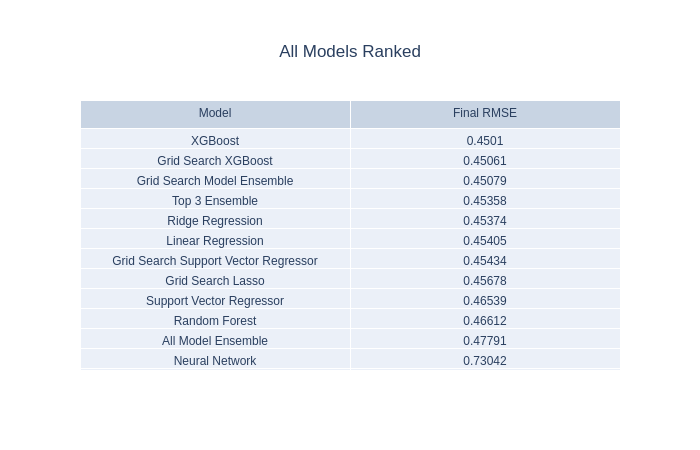

In [72]:
# Create table

models_list = ['Linear Regression','Ridge Regression','Lasso Regression','Random Forest','Support Vector Regressor',
               'XGBoost','Neural Network','Grid Search Lasso','Grid Search Support Vector Regressor',
               'Grid Search XGBoost','All Model Ensemble','Grid Search Model Ensemble', 'Top 3 Ensemble']

models_ranked_df = pd.DataFrame(data={'model': models_list, 'score': final_scores}).sort_values(by='score')

fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Final RMSE']),
                 cells=dict(values=[models_ranked_df.model, models_ranked_df.score ]))
                     ])

fig.update_layout(
    title={
        'text': "All Models Ranked",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show("png")

Surprisingly, our regular XGBoost model performs the best out of all models! We could definitely make it better by finding the right hyperparameters through a more refined grid search. Our grid searched models also perform well, with two of our ensembles coming in 3rd and 4th place. Most of these results are similar to how the models performed on our training data. This is good because it shows there is little to no overfitting and underfitting happening. We could also try some other ensembles to find the best combination. Normally ensembles work the best because they average out all of the residuals between the models. 

Speaking of residuals, let's look at a residuals plot from our best model (XGBoost)

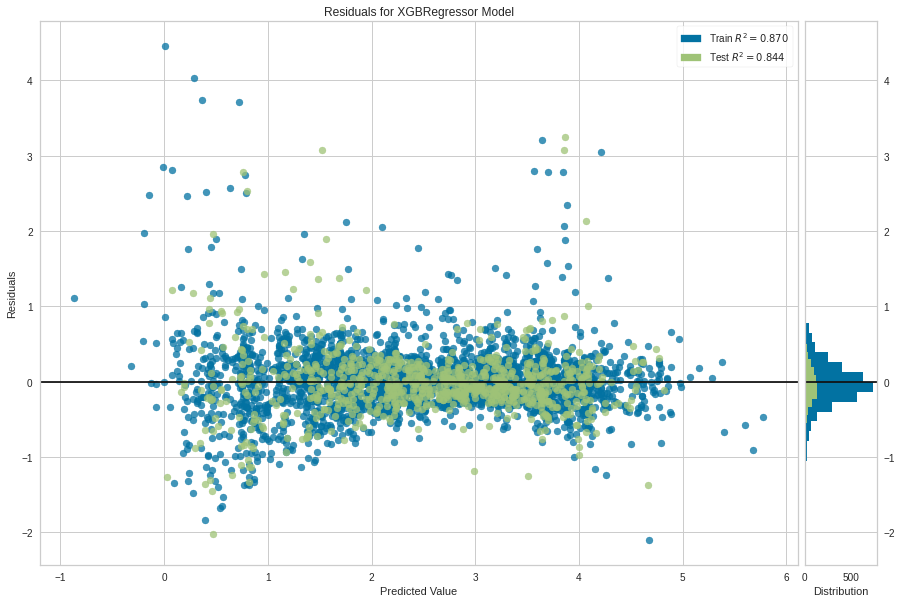

In [73]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(model_6, is_fitted=True, train_color='b', test_color='g', size=(1080,720))
visualizer.fit(x_train_scaled, y_train)
visualizer.score(x_test_scaled,y_test)
visualizer.poof() 

This plot gives a lot of useful information. First, our residuals distribution on the right is approximately normal. This is good - if it was skewed, we would not be able to accurately use this information for statistical decisions. Looking at the main section now, we can see that the training and testing residuals are very similar. Our training data seems to be a bit more spread out overall, which we can verify by checking the $R^2$ scores at the top. These measure how well our model fit the data, with 1 being perfect. Since the training score is a bit better than our testing score, there is a bit of overfitting occuring. Ideally, these would about be the same. Our residuals also center around 0 which means that they predict more than the actual value just about as often as they predict less.



XGBoost also let's us look at how important the features were in it's predictions

In [76]:
features_ranked_df

,feature,importance
3,vote_count,0.771375
20,War,0.038789
4,Language,0.031864
21,Music,0.025660
15,Comedy,0.019751
0,budget,0.016005
8,Science Fiction,0.012195
12,Animation,0.011464
5,Action,0.011264
17,Horror,0.011020


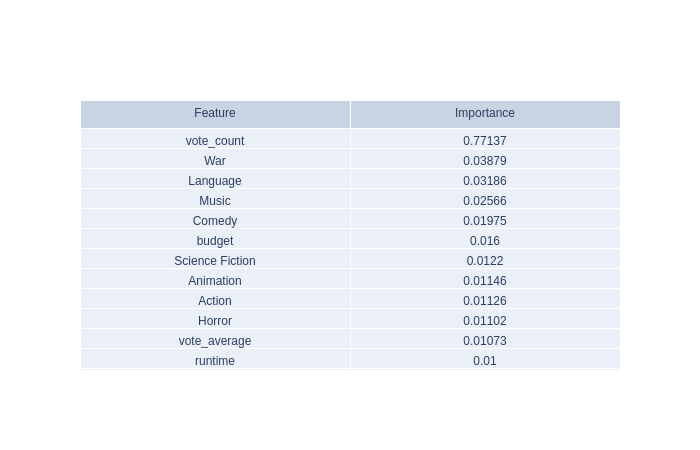

In [79]:
# Create table

features_ranked_df = pd.DataFrame(data={'feature': x_test_scaled.columns, 
                                        'importance': model_6.feature_importances_}
                                  ).sort_values(by='importance', ascending = False)

fig = go.Figure(data=[go.Table(header=dict(values=['Feature', 'Importance']),
                 cells=dict(values=[features_ranked_df.feature, [round(x,5) for x in features_ranked_df.importance]]))
                     ])


fig.update_layout(
    title={
        'text': "Features Ranked",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show("png")

It looks like vote count was the most important feature. This is expected as it was the most correlated to popularity. We have a somewhat unexpected next most important feature: the War genre. This was one of the least correlated to popularity, so it is definitely surprising to see it so high up on this list. I would have expected our other numerical features to be higher up on this list as well. There are some features not shown as they are approximately of zero importance. This is not too surprising though - there were very few instances with these features to begin with and they showed very little correlation. 

Any regression model can also provide an $R^2$ score. This is the coefficient of determination and shows how well our model fit the data between -1 and 1. The closer the score is to 1 the better. Let's take a look at how these compare.

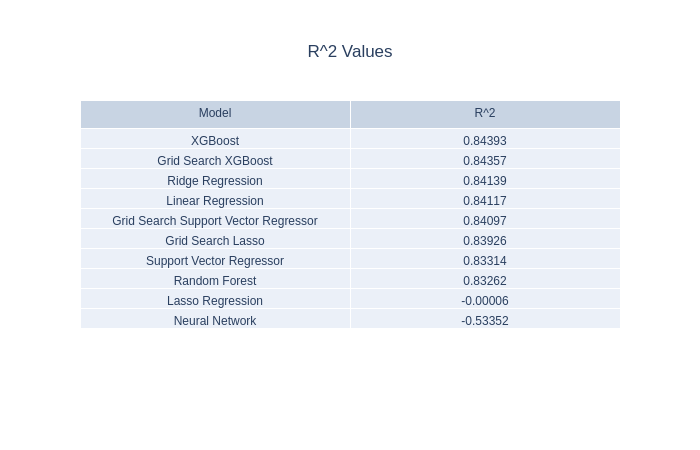

In [75]:
def score(model):
  return round(model.score(x_test_scaled, y_test),5)

# Create table

model_r2_list = [score(model_1), score(model_2), score(model_3), score(model_4), score(model_5),
                 score(model_6), score(model_7), score(model_3_grid), score(model_5_grid), score(model_6_grid)]

r2_ranked_df = pd.DataFrame(data={'model': models_list[:10], 'r2':model_r2_list}
                                  ).sort_values(by='r2', ascending = False)

fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'R^2']),
                 cells=dict(values=[r2_ranked_df.model, r2_ranked_df.r2 ]))
                     ])

fig.update_layout(
    title={
        'text': "R^2 Values",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show("png")

These results are not too surprising - they end up very similar to our RMSE table. However, these scores show how much room we still have for improvement. Although 0.84393 is a good score, it still has a bit to go before being a great model. We can also see that our original Lasso Regression model, and our Neural Network fit the data pretty terribly. We were able to improve the Lasso model through grid search, but we will need to experiment quite a bit with Neural Networks to make it more accurate. 

# Conclusion

From the models that we tried, XGBoost worked the best. I am confident that with more hyperparameter tuning and ensembling, we could achieve a much better RMSE and $R^2$ score. There are also many other models and methods we could try that are outside the scope of this project. I would like to work with on this further in the future with more data. I would also like to predict other things such as revenue or ratings, and try different feature combinations. Overall, this project gave a lot of insight into what increases the popularity of movies. I think it could be useful for production companies or independent filmmakers. I also personally learned a lot doing this and look forward to working on more complex projects in the future! 